# Exploratory Data Analysis
Starbucks Data Set  
Udacity DSND Capstone Project

## Goal
Establish offer types and channels that best stimulate purchases

Steps
- Cluster users to establish segments
- is 0 time the same for all users (start date)

- Train a regression model to predict the following purchases given: customer segment, channels, difficulty, duration, reward

How do I account for users who prefer not to get ads?

In [51]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


## Data Cleaning

### Portfolio dataset

In [25]:
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [44]:
# Separate channels into multiple columns
channels = []
for i in portfolio.channels:
    channels.extend(i)
channels = list(set(channels))

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)

portfolio.drop(columns = 'channels', inplace = True)


In [45]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,mobile,web,social,email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1


## Transcript Dataset

In [59]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [120]:
list(transcript.value[0].values())[0]

'9b98b8c7a33c4b65b9aebfe6a799e6d9'

In [121]:
#split 'value' column

transcript['value_label'] = transcript.value.apply(lambda x: [*x][0])
transcript['value'] = transcript.value.apply(lambda x: list(x.values())[0])

transcript.head()

,person,event,value,time,value_label
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


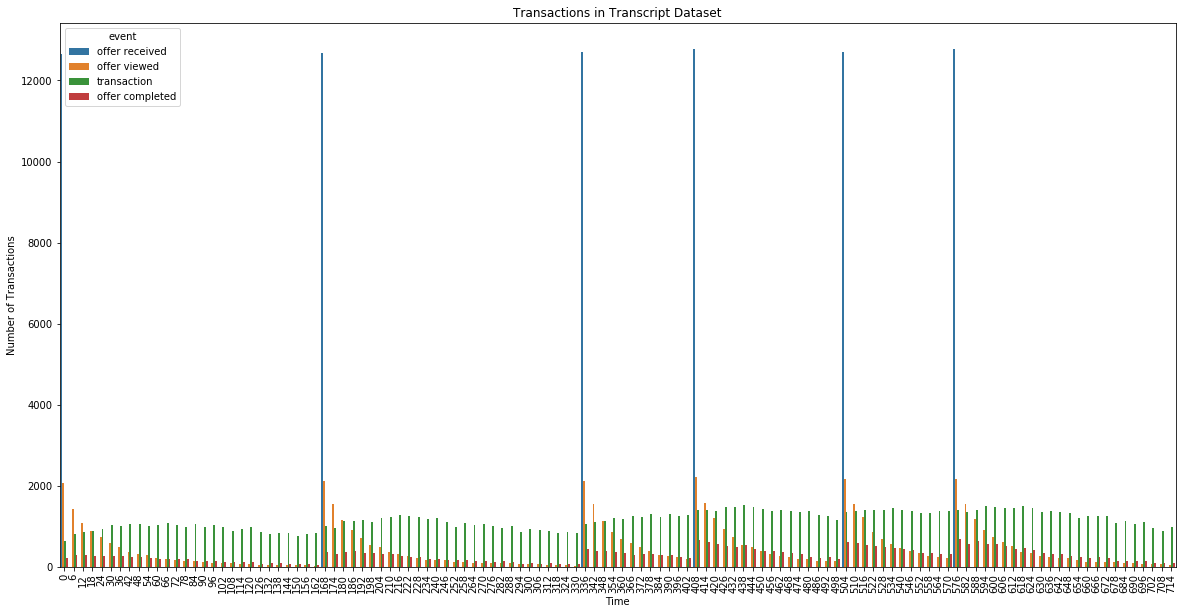

In [128]:
#what's the distribution of the time value
plt.figure(figsize=(20,10))
sns.countplot(transcript.time, hue = transcript.event)
plt.xticks(rotation=90)
plt.title('Transactions in Transcript Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [133]:
transcript[transcript.event == 'offer received'].time.value_counts()
##only 6 times that offers are received -- 

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [136]:
# are offers sent only at the same time? --NO
transcript[(transcript.event == 'offer received') & (transcript.value == '9b98b8c7a33c4b65b9aebfe6a799e6d9')].time.value_counts()

576    1326
168    1296
336    1275
408    1274
504    1261
0      1245
Name: time, dtype: int64

In [146]:
# separate transactions out from offers table. Then establish of transactions were 'influenced' or not
transactions = transcript[transcript.event == 'transaction']
offers = transcript[transcript.event != 'transaction']
transactions.head()

,person,event,value,time,value_label
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0,amount
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0,amount
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0,amount
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0,amount


In [147]:
#pivot for each person and subsequent offer
offers = offers.pivot_table(values = 'time',index = ['person','value'], columns = 'event').reset_index()
offers.columns = ['person','offer','time_completed', 'time_received','time_viewed']
offers.head()

,person,offer,time_completed,time_received,time_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,528.0,504.0,540.0


In [150]:
offers[offers.offer == '3f207df678b143eea3cee63160fa8bed']

,person,offer,time_completed,time_received,time_viewed
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,NaN,0.0,6.0
20,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,NaN,336.0,372.0
27,004b041fbfe44859945daa2c7f79ee64,3f207df678b143eea3cee63160fa8bed,NaN,168.0,NaN
38,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,NaN,504.0,528.0
...,...,...,...,...,...
63224,ffc77312ccda49fca19506f1cdf44923,3f207df678b143eea3cee63160fa8bed,NaN,504.0,NaN
63228,ffc8a38e0972421785b00f80c92c8085,3f207df678b143eea3cee63160fa8bed,NaN,0.0,NaN
63235,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,NaN,336.0,342.0
63264,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,NaN,372.0,462.0


In [149]:
# establish if transactions were 'influenced' or not, and by which offer
def influenced_check (trns_row, offers=offers):
    '''
    Checks if each transaction is influenced by an offer or not
    
    '''
    
    #filter offers table for person
    person_offers = offers[offers.person == trns_row.person]

    #cycle through offers
    for offer in person_offers.offer:
        if trns_row.time >=person_offers.time_viewed & trns_row.time <=person_offers.time_completed:
            return True, offer
        
    #if not influenced
    return False, np.nan


In [9]:
profile.head(20)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [11]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [12]:
transcript.time.value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64